# Prerequisites:
install and import some libraries we need and import the data

In [21]:
#import sys
#!pip install keras tensorflow sklearn

In [450]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis
import matplotlib.dates as mdates
import datetime as dt


In [700]:
# import historical stock data:
prices_dataset =  pd.read_csv('./^GDAXI_1y.csv', header=0)
prices_dataset[-2:]

,Date,Open,High,Low,Close,Adj Close,Volume
249,2020-02-28,11891.870117,12008.589844,11724.120117,11890.349609,11890.349609,274623700
250,2020-03-02,12030.269531,12121.599609,11624.629883,11857.870117,11857.870117,207214100


# Data preparation:
In this part, the data is manipulated so that the model can use it later

In [701]:
DAX_closing_prices_raw = prices_dataset.Close.values.astype('float32')
# turn list of closing values into list of lists of lenght 1 containing one closing value each
# so that MinMaxScaler below works:
DAX_closing_prices_raw = DAX_closing_prices_raw.reshape(len(DAX_closing_prices_raw), 1)

In [702]:
time_stamps = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in prices_dataset.Date]

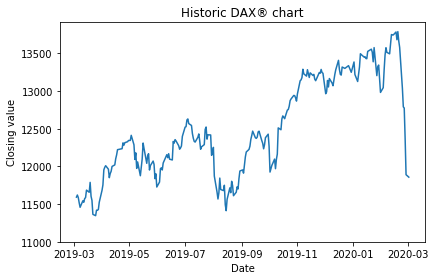

In [703]:
fig, ax = plt.subplots()

ax.set_xlabel('Date')
ax.set_ylabel('Closing value')
ax.set_title(r'Historic DAX® chart')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.plot(time_stamps,DAX_closing_prices_raw)
ax.set_ylim(ymin=11000)

plt.show()

In [704]:
# normalize data max=1 min=0
scaler = MinMaxScaler(feature_range=(0, 1))
DAX_closing_prices = scaler.fit_transform(DAX_closing_prices_raw)

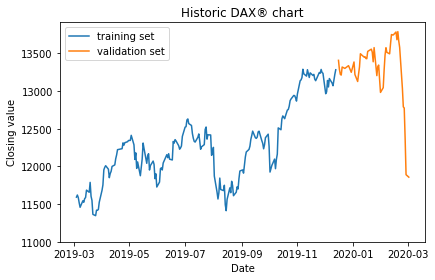

In [705]:
# define which part of the data is the training set:
train_size = int(len(DAX_closing_prices) * 0.80)
test_size = len(DAX_closing_prices) - train_size
# train: training set, test: test set:
train, test = DAX_closing_prices[0:train_size,:], DAX_closing_prices[train_size:len(DAX_closing_prices),:]

fig, ax = plt.subplots()

ax.set_xlabel('Date')
ax.set_ylabel('Closing value')
ax.set_title(r'Historic DAX® chart')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.plot(time_stamps[0:train_size],DAX_closing_prices_raw[0:train_size],label="training set")
plt.plot(time_stamps[train_size:],DAX_closing_prices_raw[train_size:],label="validation set")
ax.legend()
ax.set_ylim(ymin=11000)

plt.show()

In [706]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [715]:
# reshape into X=[DAX_t, DAX_t+1, ..., DAX_t+look_back-1] and Y=DAX_t+look_back
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# why is this one short?
trainY.shape

(196,)

At this point, `trainX` is a list of DAX closing values, for one trading day after another, i.e., `trainX[10]` id the closing value on the 11th trading day in our traning data set.

`trainY` on the other hand, is the value one day later, i.e., `trainY[10]` id the closing value on the _12th_ trading day in our traning data set.

NOTE: if `look_back` is set to anything larger than 1, then `trainX[10]` is a list of length `look_back` that contains the closing values of all trading days from the 11th to the (11+`look_back`-1)th

In [716]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Build the LSTM model:
In this step we use Keras-supplied functions to piece together a model to predict the DAX values on the next day based on one or more values before a given day.

In [717]:
model = Sequential()

model.add(LSTM(
    input_shape=(1, look_back),
    units=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

compilation time :  0.018349885940551758


# Train the model:
we supply the model with the training set and optimize it. This results in a function that correlates the input to the output data

In [718]:
model.fit(
    trainX,
    trainY,
    batch_size=128,
    epochs=100,
    validation_split=0.05)

Train on 186 samples, validate on 10 samples
Epoch 1/100
186/186 [==============================] - 1s 6ms/step - loss: 0.1630 - val_loss: 0.4448
Epoch 2/100
186/186 [==============================] - 0s 108us/step - loss: 0.1368 - val_loss: 0.3942
Epoch 3/100
186/186 [==============================] - 0s 142us/step - loss: 0.1182 - val_loss: 0.3477
Epoch 4/100
186/186 [==============================] - 0s 217us/step - loss: 0.1003 - val_loss: 0.2982
Epoch 5/100
186/186 [==============================] - 0s 216us/step - loss: 0.0843 - val_loss: 0.2547
Epoch 6/100
186/186 [==============================] - 0s 107us/step - loss: 0.0691 - val_loss: 0.2126
Epoch 7/100
186/186 [==============================] - 0s 244us/step - loss: 0.0558 - val_loss: 0.1730
Epoch 8/100
186/186 [==============================] - 0s 296us/step - loss: 0.0449 - val_loss: 0.1355
Epoch 9/100
186/186 [==============================] - 0s 291us/step - loss: 0.0327 - val_loss: 0.1029
Epoch 10/100
186/186 [========

186/186 [==============================] - 0s 84us/step - loss: 0.0045 - val_loss: 0.0030
Epoch 80/100
186/186 [==============================] - 0s 96us/step - loss: 0.0043 - val_loss: 0.0031
Epoch 81/100
186/186 [==============================] - 0s 113us/step - loss: 0.0035 - val_loss: 0.0027
Epoch 82/100
186/186 [==============================] - 0s 114us/step - loss: 0.0034 - val_loss: 0.0028
Epoch 83/100
186/186 [==============================] - 0s 127us/step - loss: 0.0037 - val_loss: 0.0028
Epoch 84/100
186/186 [==============================] - 0s 108us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 85/100
186/186 [==============================] - 0s 86us/step - loss: 0.0042 - val_loss: 0.0025
Epoch 86/100
186/186 [==============================] - 0s 93us/step - loss: 0.0037 - val_loss: 0.0025
Epoch 87/100
186/186 [==============================] - 0s 149us/step - loss: 0.0040 - val_loss: 0.0029
Epoch 88/100
186/186 [==============================] - 0s 87us/step - loss: 0.00

In [719]:
with open("model.json", "w") as json_file:
    json_file.write(model.to_json())

# Test the prediction:
We use the corelation function that results from training the model and apply it to the validation (or "test") set. This gives an indication of how the model performs.

As a first step, let's look at how the model's prediction based oon the training set looks like. 
In this case, the model "knows" both the input and the expected output.
It returns its best approximaiton of the expected output (this is basically the train step we did above).

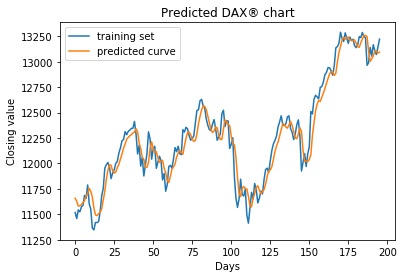

In [723]:
trainY_predicted_scaled = model.predict(trainX)
trainY_predicted = scaler.inverse_transform(trainY_predicted_scaled)

fig, ax = plt.subplots()

ax.set_xlabel('Days')
ax.set_ylabel('Closing value')
ax.set_title(r'Predicted DAX® chart')
plt.plot(scaler.inverse_transform(trainY.reshape(-1,1)), label="training set")
plt.plot(trainY_predicted, label="predicted curve")
ax.legend()
plt.show()

Now we provide the model with the test set.
If our model describes the underlying mechanisms well enough than it should return a good enough approximaion of the actual behaviour of the test data.

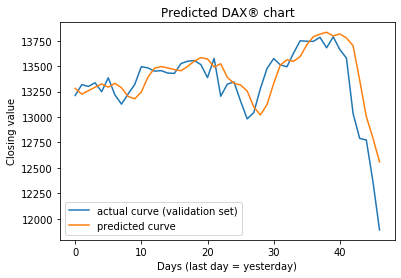

In [722]:
testY_predicted_normalized = model.predict(testX)
testY_predicted = scaler.inverse_transform(testY_predicted_normalized)

fig, ax = plt.subplots()
ax.set_xlabel('Days (last day = yesterday)')
ax.set_ylabel('Closing value')
ax.set_title(r'Predicted DAX® chart')
plt.plot(scaler.inverse_transform(testY.reshape(-1,1)), label="actual curve (validation set)")
plt.plot(testY_predicted, label="predicted curve")
ax.legend(loc=3)
plt.show()

# For later reference:

In [724]:
def plot_results_multiple(predicted_data, true_data, length):
    fig, ax = plt.subplots()

    ax.set_xlabel('Days')
    ax.set_ylabel('Closing value')
    ax.set_title(r'Predicted DAX® chart')
    
    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.plot(range(1,length+1),scaler.inverse_transform(true_data.reshape(-1, 1))[:length], label='test data')
    plt.plot(range(1,length+1),scaler.inverse_transform(np.array(predicted_data).reshape(-1, 1))[:length], label='prediction')
    ax.set_ylim(ymin=10000)
    plt.xticks(range(1,length+1))
    ax.legend()
    plt.show()
    
#predict lenght consecutive values from a real one
def predict_sequences_multiple(model, firstValue,length):
    prediction_seqs = []
    curr_frame = firstValue
    
    for i in range(length):
        print(i)
        predicted = []        
        
        print("current frame BEGIN: {}".format(curr_frame))
        model_input = curr_frame[newaxis,:,:]
        
        #if i==1:
        #    model_input=np.array([[[0.8438635 ]],[[0.82055986]]])
        print("model input: {}".format(model_input))
        
     
        model_output = model.predict(model_input)
        predicted.append(model_output[0,0])
        
        #print("predicted values: {}".format(predicted))
        print("last predicted value: {}".format(predicted[-1]))
                 
        curr_frame = curr_frame[0:]
        curr_frame = np.insert(curr_frame, i+1, predicted[-1], axis=0)
        print("current frame AFTER: {}".format(curr_frame))
        
        prediction_seqs.append(predicted[-1])
        
    return prediction_seqs

#predict_length = 5
#predictions = predict_sequences_multiple(model, testX[0], predict_length)
#plot_results_multiple(predictions, testY, predict_length)